# AB Testing Course 

## 0.1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from statsmodels.stats import api as sms

# 1.0. Load Data

In [2]:
df_raw = pd.read_csv('data/ab_data.csv')

In [3]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df_raw.shape

(294478, 5)

# 2.0. Design de Experimentos

## 2.1. Formulação das Hipóteses

In [ ]:
# H0: A conversão da nova página é de 13%
# H1: A conversão da nova página é diferente de 13%

## 2.2. Parâmetros do Experimentos

In [32]:
# nivel de confiança
confidence_level = 0.95

# nivel de significancia
significance_level = 0.05

p1 = 0.13 # ->  conversoes da páginas atual
p2 = 0.15 # ->  conversoes da nova página

# tamanho do efeito
effect_size = sms.proportion_effectsize( p1, p2 )

# Poder estatístico
power = 0.80

# sample size
sample_n = sms.NormalIndPower().solve_power(
                effect_size,
                power=power,
                alpha=significance_level
)
sample_n = math.ceil( sample_n )
sample_n

4720

In [7]:
print( f'O Tamanho total da amostra: {sample_n * 2}')
print( f'O Tamanho da amostra do grupo controle é de: {sample_n}')
print( f'O Tamanho da amostra do grupo tratamento é de: {sample_n}')

O Tamanho total da amostra: 9440
O Tamanho da amostra do grupo controle é de: 4720
O Tamanho da amostra do grupo tratamento é de: 4720


# 3.0. Análise descritiva dos dados

In [8]:
print( f'Number os rows: {df_raw.shape[0]}')
print( f'Number of columns: {df_raw.shape[1]}')

Number os rows: 294478
Number of columns: 5


## 3.1. Chack NA

In [9]:

df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## 3.2. Conferir as "flags" do teste

In [10]:
df_raw[['user_id', 'group', 'landing_page']].groupby( ['group', 'landing_page'] ).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


- usuarios duplicados no grupo tratamento e grupo controle

## 3.3. Remover duplicados

In [11]:
# agrupar duplicados
df_user_delete = df_raw[['user_id', 'group']].groupby( 'user_id' ).count().reset_index().query( 'group > 1')['user_id']

# dados sem duplicata
df1 = df_raw[ ~df_raw['user_id'].isin( df_user_delete )]

In [12]:
df1[['user_id', 'group', 'landing_page']].groupby( ['group', 'landing_page'] ).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


## 3.4. Amostragem aleatória dos grupos Controle e Tratamento

In [13]:
# Controle Group
df_control_sample = df1[df1['group'] == 'control'].sample( n=sample_n, random_state=42 )
print( f'Size of Control Group: {df_control_sample.shape[0]}')

# Tratamento Group
df_treatment_sample = df1[df1['group'] == 'treatment'].sample( n=sample_n, random_state=42 )
print( f'Size of Treatment Group: {df_treatment_sample.shape[0]}')

# Total Sample Size
df_ab = pd.concat( [df_control_sample, df_treatment_sample] ).reset_index( drop=True )

Size of Control Group: 4720
Size of Treatment Group: 4720


## 3.5. Calculo da métrica de interesse entre os Grupos ( Conversão de cada página )

In [14]:
# ============== Control Group ===============
sales = df_control_sample.loc[df_control_sample['converted'] == 1, 'converted'].sum()
visit = len( df_control_sample )

conversion_rate_control = sales / visit
print( f'Conversion Rate - Control Group: {conversion_rate_control:.4f}')

# ============== Treatment Group ===============
sales = df_treatment_sample.loc[df_treatment_sample['converted'] == 1, 'converted'].sum()
visit = len( df_control_sample )

conversion_rate_treatment = sales / visit
print( f'Conversion Rate - Treatment Group: {conversion_rate_treatment:.4f}')

Conversion Rate - Control Group: 0.1155
Conversion Rate - Treatment Group: 0.1290


# 4.0. Testes Estatísticos

## 4.1. One-sample Teste

In [15]:
import numpy as np

from scipy.stats import ttest_1samp

In [16]:
df = [ 14, 14, 16, 13, 12, 17, 15, 14, 15, 13, 15, 14 ]

# H0: u  = 15  ( A altura média das espécies das plantas, de fato, é 15 cm )
# h1: u <> 15 ( A altura média das espécies das plantas é diferente de 15 cm )

In [17]:
statstic, pvalue = ttest_1samp( df, popmean=15 )
print( f'p-value: {pvalue}')

alpha = 0.5
if pvalue < alpha:
    print( f'Rejeita a hipótese nula' )
else:
    print( f'Falha em rejeitar a hipótese nula' )
    
# Se p-value for < alpha rejeita-se H0.
#   Ou seja, a altura media das plantas eh diferente de 15 cm

# Se p-value for > alpha, não existe evidencia suficiente para se rejeita H0.
#   Ou seja, as plantas podem ter em média 15 cm

p-value: 0.12014460742498101
Rejeita a hipótese nula


## 4.2. Two-Sample T-test ( Condições Paramétricas são satisfeitas )

In [18]:
import numpy as np

from scipy.stats import shapiro, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [19]:
df1 = np.array([14, 15, 15, 16, 13, 8, 14, 17, 16, 14, 19, 20, 21, 15, 15, 16, 16, 13, 14, 12])
df2 = np.array([15, 17, 14, 17, 14, 8, 12, 19, 19, 14, 17, 22, 24, 16, 13, 16, 13, 18, 15, 13])

# H0: u1 = u2 ( A altura média das espécies dos grupos são iguais )
# H1: u1 <> u2 ( A altura média das espécies dos grupos são diferentes )

print( np.mean( df1 ))
print( np.mean( df2 ))

15.15
15.8


In [20]:
# Condições paramétricas
# 1. Amostras Indepedents
#
#
# 1. Normalmente distribuídos
#
### Teste de normalidade - Shapiro - OK
# H0: Distribuição narmalmente distribuida
# H1: Distribuição não normal
#    
# if pvalue < alpha:
#    print( f'Rejeita a hipótese nula' )
#    pvalue = 0.00001 - Digo que não é normal
#    
#else:
#    print( f'Falha em rejeitar a hipótese nula' )
#    pvalue = 0.89392 - Eh normal

stats1, pvalue1 = shapiro( df1 )
print( f'p-value: {pvalue1}')

stats2, pvalue2 = shapiro( df2 )
print( f'p-value: {pvalue2}')

# 2. Variancias iguais
print( f'\nVar 1: { np.var( df1 )}')
print( f'Var 1: { np.var( df2 )}')

stats, pvalue = ttest_ind( df1, df2, equal_var=True )
print( f'\np-value: {pvalue}' )

alpha = 0.05
if pvalue < alpha:
    print( f'Rejeita a hipótese nula')
    
else:
    print( f'Falha em rejeitar a hipótese nula')

p-value: 0.2267775684595108
p-value: 0.6782065033912659

Var 1: 7.727500000000001
Var 1: 12.260000000000002

p-value: 0.5300471010405257
Falha em rejeitar a hipótese nula


## 4.3. Mann-Whait U-test ( Condições Paramétricas não satisfeitas )

In [21]:
from scipy.stats import mannwhitneyu

In [22]:
df1 = [20, 23, 21, 20, 18, 17, 18, 14, 20, 24, 43, 19]
df2 = [24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23]

In [23]:
print( np.mean( df1 ))
print( np.mean( df2 ))

21.416666666666668
22.75


In [24]:
# H0: u1 = u2 ( A altura média das plantas dos grupos são iguais )
# H1: u1 <> u2 ( A altura média das plantas dos grupos são diferentes )

In [25]:
# Condições paramétricas
# 1. Amostras Indepedents
#
#
# 1. Normalmente distribuídos
#
### Teste de normalidade - Shapiro - OK
# H0: Distribuição narmalmente distribuida
# H1: Distribuição não normal
#    
# if pvalue < alpha:
#    print( f'Rejeita a hipótese nula' )
#    pvalue = 0.00001 - Digo que não é normal
#    
#else:
#    print( f'Falha em rejeitar a hipótese nula' )
#    pvalue = 0.89392 - Eh normal

stats1, pvalue1 = shapiro( df1 )
print( f'p-value: {pvalue1}')

stats2, pvalue2 = shapiro( df2 )
print( f'p-value: {pvalue2}')

# 2. Variancias iguais
print( f'\nVar 1: { np.var( df1 )}')
print( f'Var 1: { np.var( df2 )}')

#stats, pvalue = ttest_ind( df1, df2, equal_var=True )
stats, pvalue = mannwhitneyu( df1, df2 )
print( f'\np-value: {pvalue}' )

alpha = 0.05
if pvalue < alpha:
    print( f'Rejeita a hipótese nula')
    
else:
    print( f'Falha em rejeitar a hipótese nula (Aceita a hipótese nula)')

p-value: 0.0005459139938466251
p-value: 0.9021502137184143

Var 1: 48.743055555555564
Var 1: 9.6875

p-value: 0.07217495133598324
Falha em rejeitar a hipótese nula (Aceita a hipótese nula)


## 4.4.  One-Way ANOVA

In [26]:
df = pd.DataFrame( { 'A': [25, 30, 28, 36, 29],
                     'B': [45, 55, 29, 56, 40],
                     'C': [30, 29, 33, 37, 27],
                     'D': [54, 60, 51, 62, 73]} )

In [27]:
df_melt =pd.melt( df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'] )
df_melt.columns = ['index', 'treatment', 'value']
df_melt.head()

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


In [28]:
print( f'pvalue - Grupo A: { shapiro( df["A"] )}' )
print( f'pvalue - Grupo B: { shapiro( df["B"] )}' )
print( f'pvalue - Grupo C: { shapiro( df["C"] )}' )
print( f'pvalue - Grupo D: { shapiro( df["D"] )}' )

print( f'pvalue - Grupo A: { np.var( df["A"] )}' )
print( f'pvalue - Grupo B: { np.var( df["B"] )}' )
print( f'pvalue - Grupo C: { np.var( df["C"] )}' )
print( f'pvalue - Grupo D: { np.var( df["D"] )}' )

pvalue - Grupo A: ShapiroResult(statistic=0.9316344261169434, pvalue=0.6075581908226013)
pvalue - Grupo B: ShapiroResult(statistic=0.9264494776725769, pvalue=0.5723667740821838)
pvalue - Grupo C: ShapiroResult(statistic=0.9529604315757751, pvalue=0.7583119869232178)
pvalue - Grupo D: ShapiroResult(statistic=0.9448273181915283, pvalue=0.7002365589141846)
pvalue - Grupo A: 13.040000000000001
pvalue - Grupo B: 100.4
pvalue - Grupo C: 12.16
pvalue - Grupo D: 58.0


In [29]:
stats, pvalue = f_oneway( df["A"], df["B"], df["C"], df["D"] )
print( f'pvalue: {pvalue}')

# H0: Não há diferença ma altura média
# H1: Há diferença na altuara média

alpha = 0.05

if pvalue < alpha:
    print( 'Rejeita a hipótese nula' )
else:
    print( 'Falha em rejeitar a hipótese nula - Aceita a H0')

pvalue: 2.639241146210922e-05
Rejeita a hipótese nula


In [30]:
tukey = pairwise_tukeyhsd( endog=df_melt['value'],
                           groups=df_melt['treatment'],
                           alpha=0.5 )
print( tukey )

 Multiple Comparison of Means - Tukey HSD, FWER=0.50 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B     15.4 0.0251   8.5506 22.2494   True
     A      C      1.6 0.9867  -5.2494  8.4494  False
     A      D     30.4 0.0001  23.5506 37.2494   True
     B      C    -13.8 0.0482 -20.6494 -6.9506   True
     B      D     15.0 0.0296   8.1506 21.8494   True
     C      D     28.8 0.0001  21.9506 35.6494   True
-----------------------------------------------------


<AxesSubplot:xlabel='treatment', ylabel='value'>

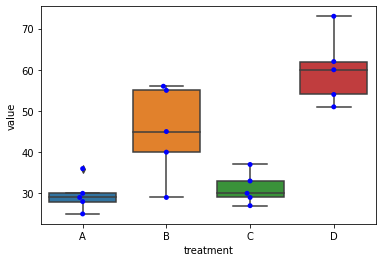

In [31]:
sns.boxplot( x='treatment', y='value', data=df_melt )
sns.swarmplot( x='treatment', y='value', data=df_melt, color='b' )